In [10]:
import os  
  
cwd = os.getcwd()
cwd

'C:\\Users\\laceto\\OneDrive - Gen Re AzureAD\\Desktop\\lavoro\\Personal projects\\finance\\myfinance 20240708\\data'

In [3]:
# !pip install -r "C:/Users/laceto/OneDrive - Gen Re AzureAD/Desktop/lavoro/Personal projects/finance/myfinance 20240708/requirements.txt"

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.6 MB 2.8 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/11.6 MB 5.0 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/11.6 MB 5.1 MB/s eta 0:00:02
   -------------- ------------------------- 4.2/11.6 MB 5.4 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.6 MB 5.3 MB/s eta 0:00:02
   -------------------- ------------------- 6.0/11.6 MB 5.1 MB/s eta 0:00:02
   ------------------------- -------------- 7.3/11.6 MB 5.1 MB/s eta 0:00:01
   ---------------------------- ----------- 8.4/11.6 MB 5.1 MB/s eta 0:00:01
   ------------------------------- -------- 9.2/11.6 MB 5.1 MB/s eta 0:00:01
   --------------------------------- ------ 9.7/11.6 MB 4.9 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.6 MB 4.7 MB/s eta 0:00:01
   ---------------

In [11]:
import sys  
sys.path.insert(0, 'data')
from AT_funs import *

In [99]:
filename_bm = 'FTSEMIB.MI.xlsx'
bm_df = read_xlsx(filename_bm)
bm_name = filename_bm.replace('xlsx', '')

# files = [file for file in os.listdir('data') if file.endswith(".xlsx") and file != "FTSEMIB.MI.xlsx" and file != "marginabili.xlsx" and file != "sectors.xlsx" and file != "output_signals.xlsx" and file != "PTF.xlsx", and file == "A2A.MI.xlsx"]
# print(len(files))

exclude_files = {"FTSEMIB.MI.xlsx", "marginabili.xlsx", "sectors.xlsx", "output_signals.xlsx", "PTF.xlsx"}
# include_files = {"A2A.MI.xlsx"}
# files = [file for file in os.listdir('data') if file.endswith(".xlsx") and file not in exclude_files and file in include_files]
files = [file for file in os.listdir(cwd) if file.startswith("IP.MI.xlsx") and file not in exclude_files]
print(len(files))
files

1


['IP.MI.xlsx']

In [100]:
window_bo = 100
fast = 20
slow = 50
st = 50
mt = 100
lt = 150
lvl = 3
bm_col = 'close'
dgt = 5
window_exp = 100
starting_capital = 100000
lot = 100
mn = -0.0025
mx = -0.0075
# avg = (mn + mx) / 2
tolerance= -0.1
equal_weight = 0.05
span= 5
fx = 1

# Read all xlsx files
dfs = []
last_row_dfs = [None] * len(files)
failed = []
signal_df = pd.DataFrame()
signal_list = []

regime_df = pd.DataFrame()
last_row_df = pd.DataFrame()
signal_df = pd.DataFrame()
dfs_list = []
last_row_list = []
failed = []

In [101]:
for file in files:
    # file_path = os.path.join('data', file)
    df = pd.read_excel(file)
    if df.shape[0] >= 1000:
        dfs.append(df)

print('letti tutti i files')

letti tutti i files


In [102]:
i = 0
ohlc = ['open','high','low','close']
_o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
ticker = dfs[i]['ticker'][0]

In [103]:
dfs = relative(dfs[i],_o,_h,_l,_c, bm_df, bm_col, dgt, rebase=True)

In [104]:
dfs = detect_regime(dfs, bm_df)

In [105]:
dfs = get_equity_risk(dfs, tolerance, mn, mx, span)

<Axes: xlabel='date'>

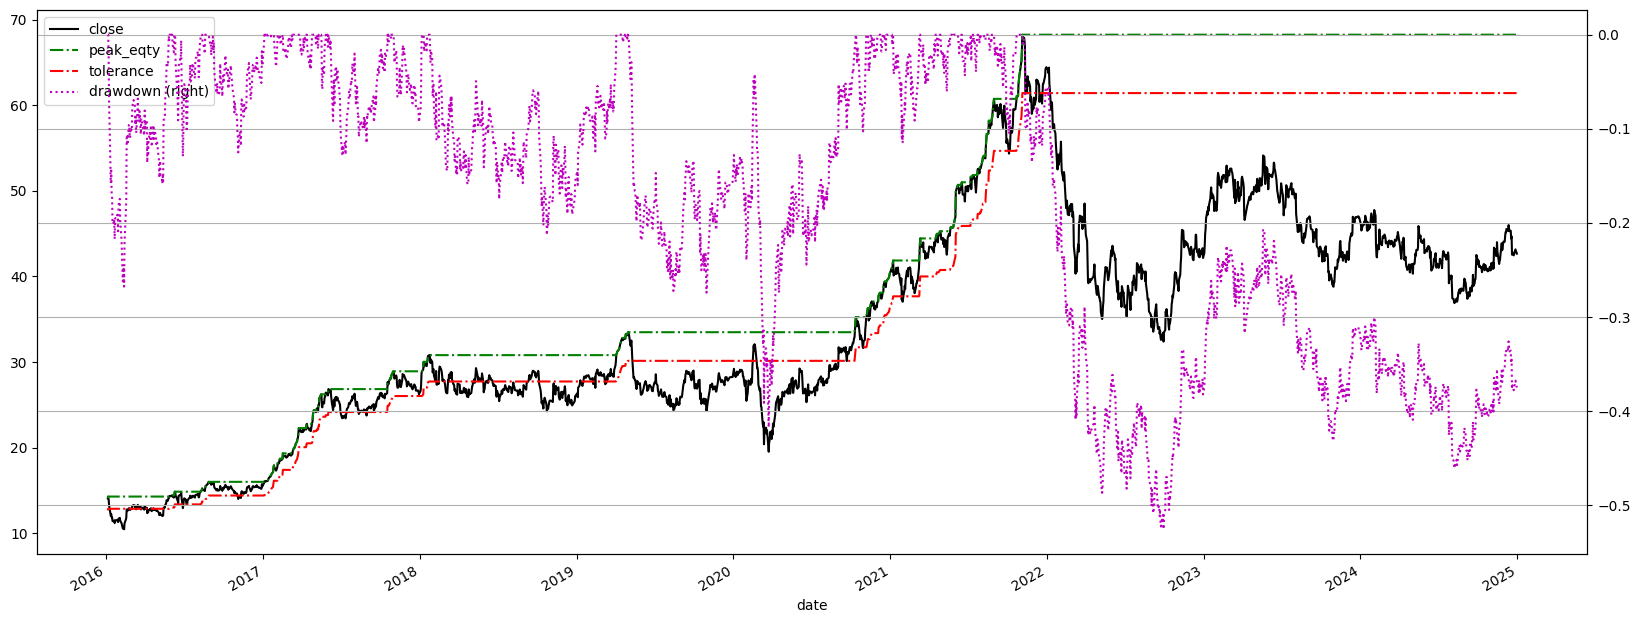

In [106]:
dfs.set_index('date')[['close','peak_eqty','tolerance', 'drawdown']].plot(  
    style=['k','g-.','r-.','m:'],  
    secondary_y=['drawdown'],  
    figsize=(20,8),  
    grid=True  
) 

<Axes: title={'center': 'IP.MI equity risk '}, xlabel='date'>

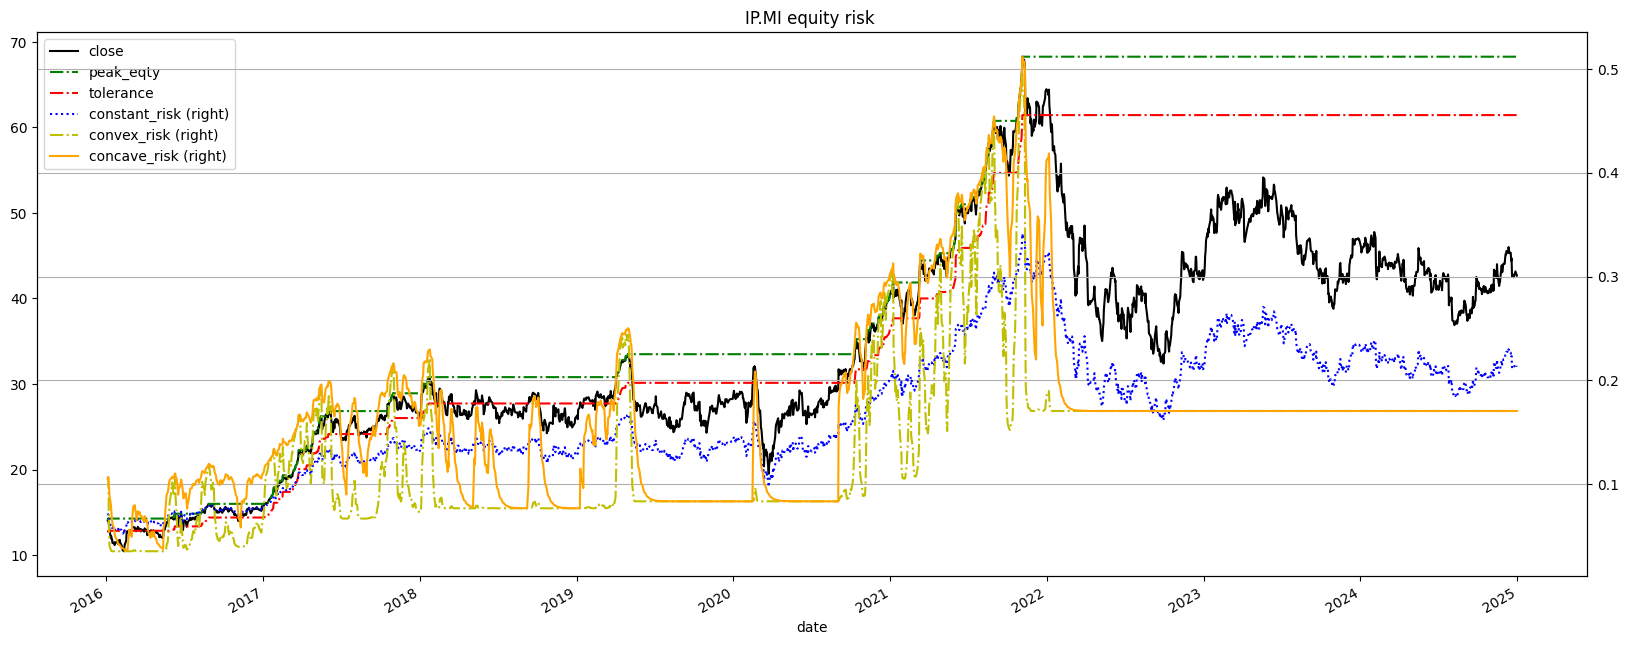

In [107]:
dfs.set_index('date')[['close', 'peak_eqty', 'tolerance', 'constant_risk','convex_risk','concave_risk']].plot(
    figsize= (20,8),
    grid=True,
    secondary_y=['constant_risk','convex_risk','concave_risk'],
    style= ['k','g-.','r-.','b:','y-.', 'orange'], 
    title= str(ticker) + ' equity risk '
)

<Axes: title={'center': 'IP.MI equity risk '}, xlabel='date'>

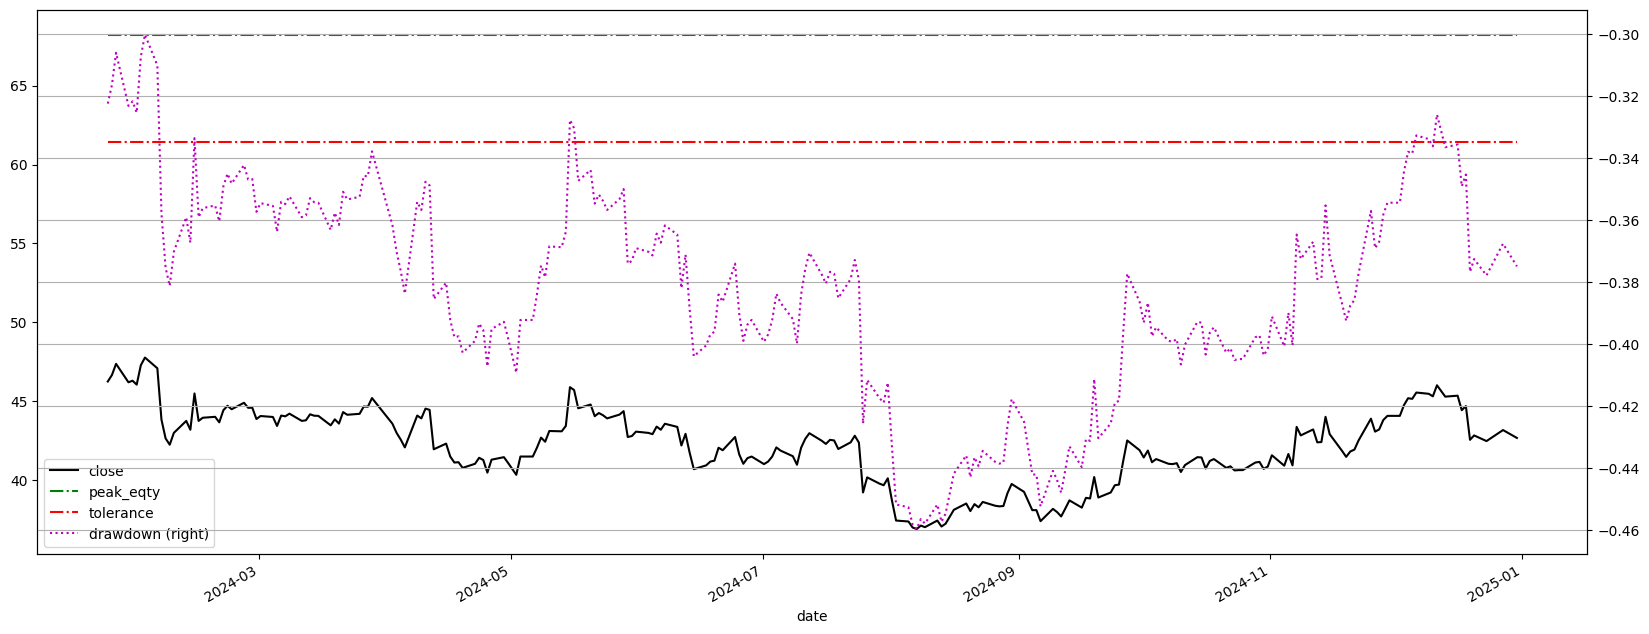

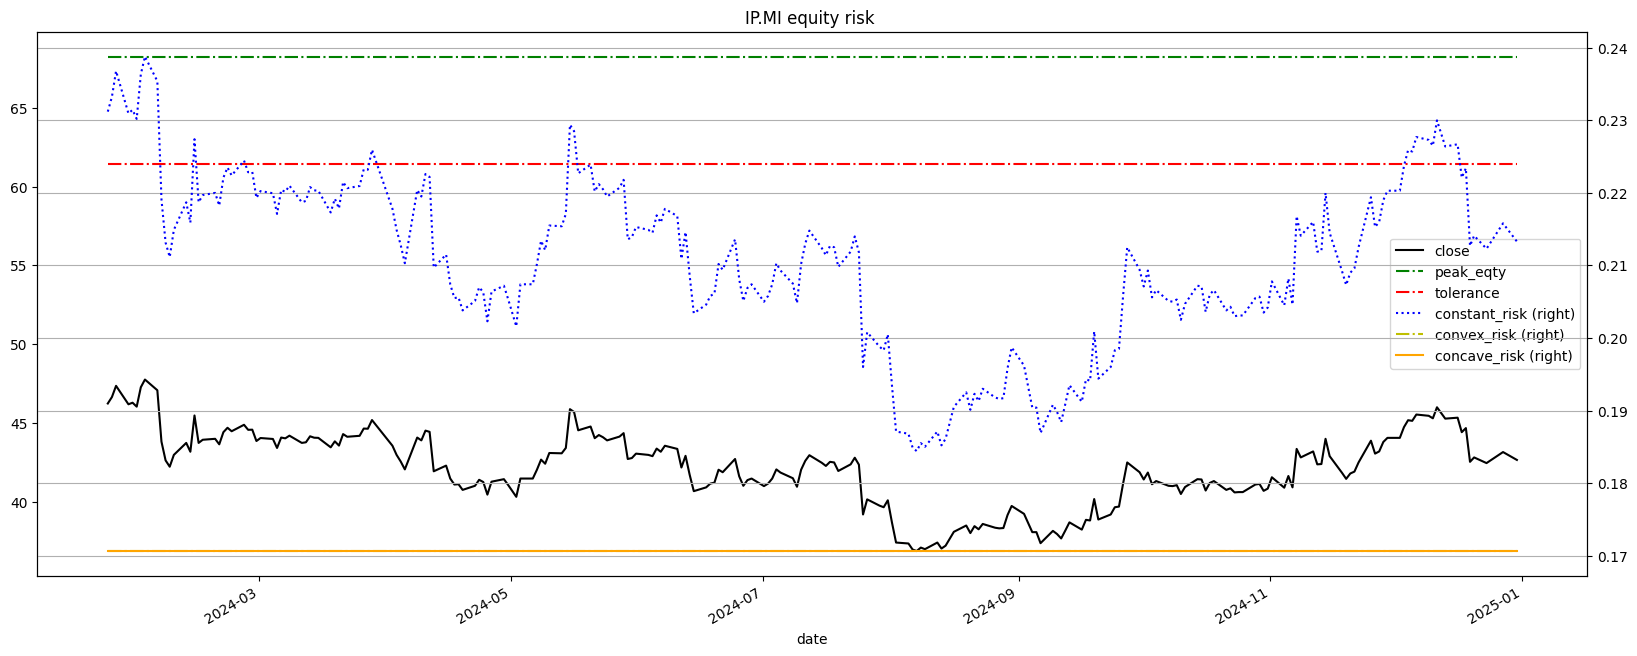

In [108]:
# Assuming your date column is named 'date'  
dfs['date'] = pd.to_datetime(dfs['date'])   # Convert to datetime format if needed  
  
# Filter the DataFrame  
dfs_filtered = dfs[dfs['date'] > '2024-01-24']  
  
# Plot the filtered data  
dfs_filtered.set_index('date')[['close','peak_eqty','tolerance', 'drawdown']].plot(  
    style=['k','g-.','r-.','m:'],  
    secondary_y=['drawdown'],  
    figsize=(20,8),  
    grid=True  
)  

dfs_filtered.set_index('date')[['close', 'peak_eqty', 'tolerance', 'constant_risk','convex_risk','concave_risk']].plot(
    figsize= (20,8),
    grid=True,
    secondary_y=['constant_risk','convex_risk','concave_risk'],
    style= ['k','g-.','r-.','b:','y-.', 'orange'], 
    title= str(ticker) + ' equity risk '
)

In [110]:
# eqty_risk_shares(px,sl,eqty= df['constant'].iloc[i], risk= constant_risk,fx=fx,lot=lot)
# dfs.columns

In [111]:
dfs = get_returns(dfs, 'rrg')

In [112]:
def get_shares(df, starting_capital, lot, mn, mx, tolerance, equal_weight, span, fx, s):
    
    # df[s] = df[s].fillna(0)
    
    shs_fxd = shs_ccv = shs_cvx = shs_eql = 0
    df.loc[df.index[0],'constant'] = df.loc[df.index[0],'concave'] = starting_capital
    df.loc[df.index[0],'convex'] = df.loc[df.index[0],'equal_weight'] = starting_capital
    ccy_name = 'EUR'
    df[ccy_name] = 1
    shs_fxd = shs_ccv = shs_cvx = shs_eql = 0
    avg = (mn + mx) / 2

    # return_variable = str(s)+'_chg1D_fx'

    for i in range(1,len(df)):
        df['equal_weight'].iat[i] = df['equal_weight'].iat[i-1] + df[str(s)+'_chg1D_fx'].iloc[i] * shs_eql
        df['constant'].iat[i] = df['constant'].iat[i-1] + df[str(s)+'_chg1D_fx'].iloc[i] * shs_fxd
        df['concave'].iat[i] = df['concave'].iat[i-1] + df[str(s)+'_chg1D_fx'].iloc[i] * shs_ccv
        df['convex'].iat[i] = df['convex'].iat[i-1] + df[str(s)+'_chg1D_fx'].iloc[i] * shs_cvx

        ccv = risk_appetite(eqty= df['concave'][:i], tolerance=tolerance, 
                            mn= mn, mx=mx, span=5, shape=-1)
        cvx = risk_appetite(eqty= df['convex'][:i], tolerance=tolerance, 
                            mn= mn, mx=mx, span=5, shape=1)

        
        if (df[s].iloc[i-1] ==0) & (df[s].iloc[i] !=0):
            px = df['close'].iloc[i]
            sl = df['stop_loss'].iloc[i]
            fx  = df[ccy_name].iloc[i]
            shs_eql = (df['equal_weight'].iloc[i]  * equal_weight  *fx//(px * lot)) * lot

            

            if px != sl:
                shs_fxd = eqty_risk_shares(px,sl,eqty= df['constant'].iloc[i],
                                            risk= avg,fx=fx,lot=lot)
                shs_ccv = eqty_risk_shares(px,sl,eqty= df['concave'].iloc[i],
                                                risk= ccv.iloc[-1],fx=fx,lot=lot)
                shs_cvx = eqty_risk_shares(px,sl,eqty= df['convex'].iloc[i],
                                                risk= cvx.iloc[-1],fx=fx,lot=lot)
    
    
    df['shs_eql'] = -(df['equal_weight'] * equal_weight  *fx//(df['close'].iloc[i] * lot)) * lot
    df['shs_fxd'] = ((df['constant'] -df['constant'].shift())  / df[str(s)+'_chg1D_fx'])
    df['shs_ccv'] = ((df['concave'] -df['concave'].shift())  / df[str(s)+'_chg1D_fx'])
    df['shs_cvx'] = ((df['convex'] -df['convex'].shift())  / df[str(s)+'_chg1D_fx'])
    
    df['peak_eqty'] = df['close'].cummax()
    df['constant_risk'] = -df['close'] * avg
    df['convex_risk'] = -risk_appetite(df['close'], tolerance, mn, mx, span, shape=1) * df['peak_eqty']
    df['concave_risk'] = -risk_appetite(df['close'], tolerance, mn, mx, span, shape=-1) * df['peak_eqty']
    df['tolerance'] = df['peak_eqty'] * (1 + tolerance )
    df['drawdown'] = df['close'] / df['peak_eqty'] -1
    
    return df

In [113]:
dfs = get_shares(dfs, starting_capital, lot, mn, mx, tolerance, equal_weight, span, fx, s= 'rrg')

In [114]:
dfs['rrg'].unique()

array([ 0.,  1., -1.])

In [115]:
dfs[['date', 'rrg', 'stop_loss', 'shs_eql', 'shs_fxd', 'shs_ccv', 'shs_cvx']]

,date,rrg,stop_loss,shs_eql,shs_fxd,shs_ccv,shs_cvx
0,2016-01-04 08:00:00,0.0,NaN,-100.0,NaN,NaN,NaN
1,2016-01-05 08:00:00,0.0,NaN,-100.0,NaN,NaN,NaN
2,2016-01-06 08:00:00,0.0,NaN,-100.0,NaN,NaN,NaN
3,2016-01-07 08:00:00,0.0,NaN,-100.0,NaN,NaN,NaN
4,2016-01-08 08:00:00,0.0,NaN,-100.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2283,2024-12-19 08:00:00,-1.0,46.18,-100.0,-1400.0,-2100.0,-1100.0
2284,2024-12-20 08:00:00,-1.0,46.18,-100.0,-1400.0,-2100.0,-1100.0
2285,2024-12-23 08:00:00,-1.0,46.18,-100.0,-1400.0,-2100.0,-1100.0
2286,2024-12-27 08:00:00,-1.0,46.18,-100.0,-1400.0,-2100.0,-1100.0


In [119]:
# Set display options to show all rows and columns  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
  
# View the full DataFrame  
dfs[['date', 'close', 'rrg', 'stop_loss', 'shs_eql', 'shs_fxd', 'shs_ccv', 'shs_cvx', 'constant_risk','convex_risk','concave_risk']]  

,date,close,rrg,stop_loss,shs_eql,shs_fxd,shs_ccv,shs_cvx,constant_risk,convex_risk,concave_risk
0,2016-01-04 08:00:00,14.06,0.0,NaN,-100.0,NaN,NaN,NaN,0.07030,0.105450,0.105450
1,2016-01-05 08:00:00,14.27,0.0,NaN,-100.0,NaN,NaN,NaN,0.07135,0.107025,0.107025
2,2016-01-06 08:00:00,13.92,0.0,NaN,-100.0,NaN,NaN,NaN,0.06960,0.084934,0.104147
3,2016-01-07 08:00:00,13.23,0.0,NaN,-100.0,NaN,NaN,NaN,0.06615,0.053460,0.096819
4,2016-01-08 08:00:00,12.93,0.0,NaN,-100.0,NaN,NaN,NaN,0.06465,0.040634,0.088730
5,2016-01-11 08:00:00,12.02,0.0,NaN,-100.0,NaN,NaN,NaN,0.06010,0.036942,0.081267
6,2016-01-12 08:00:00,12.21,0.0,NaN,-100.0,NaN,NaN,NaN,0.06105,0.036017,0.075087
7,2016-01-13 08:00:00,11.85,0.0,NaN,-100.0,NaN,NaN,NaN,0.05925,0.035770,0.069870
8,2016-01-14 08:00:00,11.83,0.0,NaN,-100.0,NaN,NaN,NaN,0.05915,0.035702,0.065413
9,2016-01-15 08:00:00,11.40,0.0,NaN,-100.0,NaN,NaN,NaN,0.05700,0.035683,0.061577
